# PART B: RECURRENT NEURAL NETWORK (50 marks)

## Task
Build a next-word predictor, given a sequence of words. The input to your model is a sequence of words of any length (could be one word, could be five words, etc.). The output of your model is a word that follows that sequence of words. In principle, given an input to your model, you can ask your model to predict the next ten words, by asking your model to predict the next word ten times.

## Submission requirements for Part B
1. Submit a zip file containing all the project files (source code, Jupyter notebook .ipynb file, .html file, and best neural network weights .h5, slides).
2. Submit online via the Assignment link.

## Evaluation criteria:
- **Background research and exploratory data analysis** (10 marks)
- **Feature engineering** (10 marks)
- **Modelling and evaluation** (10 marks)
- **Model improvement** (10 marks)
- **Demo/Presentation and quality of report (Jupyter)** (10 marks)


# Recurrent Neural Network (RNN)

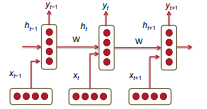

## Overview
A Recurrent Neural Network (RNN) is a type of artificial neural network designed for sequential data processing. Unlike traditional feedforward neural networks, RNNs have connections that form a directed cycle, allowing them to maintain a hidden state that captures information about previous inputs in the sequence.

## Key Concepts
- **Sequential Processing:** RNNs are well-suited for tasks involving sequences, such as time series data, natural language, and speech processing.
- **Hidden State:** RNNs maintain a hidden state that evolves as the network processes each element in the input sequence. This hidden state serves as a memory, allowing the network to capture dependencies and context from past inputs.
- **Vanishing Gradient Problem:** Training RNNs can be challenging due to the vanishing gradient problem, where gradients diminish as they are backpropagated through time, making it difficult for the network to learn long-range dependencies.


## Challenges and Variants
- **Long Short-Term Memory (LSTM):** To address the vanishing gradient problem, LSTM networks, a type of RNN variant, were introduced. LSTMs have gating mechanisms that control the flow of information in and out of the hidden state.
- **Gated Recurrent Unit (GRU):** Another variant similar to LSTM, GRUs have a simplified architecture with fewer parameters, making them computationally more efficient.

In the context of our task, building a next-word predictor, an RNN is employed to capture dependencies and patterns in the sequential data of word sequences, enabling the model to predict the next word in a given sequence.


In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy
import tensorflow as tf 

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, GRU, Attention, LayerNormalization, Concatenate, Input
from tensorflow.keras.models import Model

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import math
from nltk.translate.bleu_score import sentence_bleu

warnings.filterwarnings('ignore')

os.environ['PYTHONHASHSEED'] = '1'
keras.utils.set_random_seed(42)
tf.random.set_seed(41)
#generate random weights for reproducibility
np.random.seed(42)
import random
random.seed(42)

# Data Analysis

In [2]:
with open ('train.csv', 'r') as f:
    data = f.read()
    data = data.split('\n')

In [3]:
lines = data
lines = [line for line in lines if line]

# Find the longest sentence based on the number of words
word_counts = [len(line.split()) for line in lines]
longest_sentence_index = word_counts.index(max(word_counts))
longest_sentence = lines[longest_sentence_index]
print(f"Longest Sentence: {longest_sentence}")
print(f"Number of Words in Longest Sentence: {max(word_counts)}\n\n")
most = max(word_counts)

# Find the most robust sentence based on word count
sentences_word_count = [len(sentence.split()) for sentence in lines]
most_robust_sentence_index = sentences_word_count.index(max(sentences_word_count))
most_robust_sentence = lines[most_robust_sentence_index]
print(f"Most Robust Sentence: {most_robust_sentence}")
print(f"Word Count of Most Robust Sentence: {max(sentences_word_count)}\n\n")

# Find the most robust sentence based on character count
sentences_character_count = [len(sentence) for sentence in lines]
most_robust_sentence_index = sentences_character_count.index(max(sentences_character_count))
most_robust_sentence = lines[most_robust_sentence_index]
print(f"Most Robust Sentence: {most_robust_sentence}")
print(f"Character Count of Most Robust Sentence: {max(sentences_character_count)}")


Longest Sentence: "Every act of love is a tribute, a tribute to the boundless power, the boundless power of the heart, to heal and transform, to connect and uplift, to create a legacy of warmth and affection."
Number of Words in Longest Sentence: 35


Most Robust Sentence: "Every act of love is a tribute, a tribute to the boundless power, the boundless power of the heart, to heal and transform, to connect and uplift, to create a legacy of warmth and affection."
Word Count of Most Robust Sentence: 35


Most Robust Sentence: "Every challenge overcome is a testament, a testament to your indomitable spirit, a living proof of your strength and resilience, a reminder that you are capable of conquering any obstacle that comes your way."
Character Count of Most Robust Sentence: 210


# Data Preprocessing

In [4]:
data.remove(data[0])
data.remove(data[-1])

#remove the " as well as the commas and fullstops

for i in range(len(data)):
    data[i] = data[i].replace('"', '')
    data[i] = data[i].replace(',', '')
    data[i] = data[i].replace('.', '')
    data[i] = data[i].replace(';', '')


In [5]:
data

["Embrace the beauty of every sunrise it's a fresh chance to paint your world with joy",
 'Embrace challenges they are the stepping stones to your greatest victories',
 'Embrace the rhythm of life and let it dance through your soul',
 'Embrace kindness for it has the power to change the world one heart at a time',
 'Embrace the journey for it leads to the destination of your dreams',
 'Embrace your uniqueness for it is the fingerprint of your soul on the universe',
 'Embrace the present moment for it is the only one that truly exists',
 'Embrace your fears for they hold the key to unlocking your true potential',
 'Embrace gratitude and watch how it multiplies the blessings in your life',
 'Embrace the rain for it nourishes the seeds of your future success',
 'Embrace the whispers of your heart they carry the wisdom of the universe',
 'Embrace laughter for it is the music of a joyful heart',
 'Embrace the power of forgiveness for it sets you free from the chains of the past',
 'Embrace 

In [6]:
#split the quotes into a list of words

for i in range(len(data)):
    data[i] = data[i].split(' ')


## Generating more input output pairs

![rolling window](image.png)

We can use the following algorithm to split the data into input and output pairs in the format seen in the image.

In [7]:
#convert quotes into more data friendly format using rolling window

def convert_quotes(data):
    quotes = []
    for quote in data:
        for window_size in range(2, len(quote)):
            for i in range(len(quote)):
                quotes.append(quote[i:i+window_size])
    return quotes


quotes = convert_quotes(data)

In [8]:
#convert quotes into format suitable for tokenization

quotestoken = [' '.join(quote) for quote in quotes]

#tokenize quotes

tokenizer = Tokenizer()
tokenizer.fit_on_texts(quotestoken)
sequences = tokenizer.texts_to_sequences(quotestoken)
total_words = len(tokenizer.word_index) + 1

In [9]:
#now we pad the sequences so that they are all the same length
max_sequence_len = max([len(x) for x in sequences])

padded_sequences = pad_sequences(sequences, maxlen = max_sequence_len, padding = 'pre')

In [10]:
#split the data into X and ywe cacn take the last word as the y and the rest as the X

X = padded_sequences[:, :-1]
y = padded_sequences[:, -1]

#now we need to one hot encode the y values

y = to_categorical(y, num_classes=total_words)

## Modeling

As we are done with the data preprocessing, we can now move on to the modeling part. We will be using the following models:

1. **LSTM** (Long Short Term Memory)
2. **GRU** (Gated Recurrent Unit)
3. **BiLSTM** (Bidirectional LSTM)
4. **BiGRU** (Bidirectional GRU)
5. **Stacked RNN** (Ensemble of different RNN models)



In [11]:
input_len = max_sequence_len - 1

model = Sequential()
model.add(Embedding(total_words, 10, input_length=input_len))

# Add LSTM layer with 256 units.
model.add(LSTM(256))

# Control overfitting.
model.add(Dropout(0.3))

# Add output layer
model.add(Dense(total_words, activation='softmax'))

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, epochs=10, verbose=1)

model.summary()

Epoch 1/10
3922/3922 [==============================] - 36s 7ms/step - loss: 4.1099 - accuracy: 0.2369
Epoch 2/10
3922/3922 [==============================] - 25s 6ms/step - loss: 2.3978 - accuracy: 0.4898
Epoch 3/10
3922/3922 [==============================] - 25s 6ms/step - loss: 1.9288 - accuracy: 0.5727
Epoch 4/10
3922/3922 [==============================] - 25s 6ms/step - loss: 1.7105 - accuracy: 0.6113
Epoch 5/10
3922/3922 [==============================] - 27s 7ms/step - loss: 1.5823 - accuracy: 0.6366
Epoch 6/10
3922/3922 [==============================] - 30s 8ms/step - loss: 1.4946 - accuracy: 0.6531
Epoch 7/10
3922/3922 [==============================] - 30s 8ms/step - loss: 1.4381 - accuracy: 0.6637
Epoch 8/10
3922/3922 [==============================] - 31s 8ms/step - loss: 1.3940 - accuracy: 0.6717
Epoch 9/10
3922/3922 [==============================] - 30s 8ms/step - loss: 1.3623 - accuracy: 0.6778
Epoch 10/10
3922/3922 [==============================] - 30s 8ms/step - l

In [12]:
def generate_text(model, tokenizer, max_sequence_len, seed_text, next_words=1): #def next_words for later use
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        
        predicted_probs = model.predict(token_list)[0]
        predicted_id = np.argmax(predicted_probs)
        
        predicted_word = tokenizer.index_word.get(predicted_id, "")
        seed_text += " " + predicted_word

    return seed_text



In [13]:
#use random seed text from the data

seed_text = 'embrace each day'
                


#generate text

generated_text = generate_text(model, tokenizer, max_sequence_len, seed_text)
print('Predicted Sentence/Quote:', generated_text)

1/1 [==============================] - 2s 2s/step
Predicted Sentence/Quote: embrace each day away


## Evaluation

Although we can use the model to predict words, we have no way of knowing how good the model is as there are no fixed right or wrong sentences in the English language. So, we will be using the following metrics to evaluate the model instead of basing our evaluation on the accuracy of the model. First thing we can consider is the **perplexity** of the model. Perplexity is a metric that is used to evaluate how well a probability model predicts a sample. 


Perplexity:
It is given by the following formula: 


![perplexity formula](image.png)

Where:
- \(N\) is the total number of words in the dataset.
- \(P(w_i)\) is the probability assigned by the language model to the \(i\)-th word in the dataset.

This is essentially just the exponential of the crossentropy (the loss) of the model. To make the process more efficient, i will apply it only at the end.

In [15]:
#Lets save the first model for comparison with other models later on

RNNdf = pd.DataFrame(columns=['Model Name', 'Generated Text', '"Loss"', '"Accuracy"', 'History'])

# Save the LSTM model information
model_name = 'LSTM'
loss_value = history.history['loss'][-1]
accuracy_value = history.history['accuracy'][-1]

# Create a dictionary with the new values
new_row = {
    'Model Name': model_name,
    'Generated Text': generated_text,
    '"Loss"': loss_value,
    '"Accuracy"': accuracy_value,
    'History': [history]
}

# Concatenate the DataFrames
RNNdf = pd.concat([RNNdf, pd.DataFrame([new_row])], ignore_index=True)

NameError: name 'history' is not defined

In [16]:
model = Sequential()
model.add(Embedding(total_words, 10, input_length=input_len))
model.add(GRU(256))
model.add(Dropout(0.3))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_gru = model.fit(X, y, epochs=10, verbose=1)

# Generate text
generated_text_gru = generate_text(model, tokenizer, max_sequence_len, seed_text)

# Save GRU model information
model_name_gru = 'GRU'
loss_value_gru = np.min(history_gru.history['loss'])  # Use min loss as an example
accuracy_value_gru = np.max(history_gru.history['accuracy'])  # Use max accuracy as an example
# Append GRU information to the DataFrame
RNNdf = pd.concat([RNNdf, pd.DataFrame([{
    'Model Name': model_name_gru,
    'Generated Text': generated_text_gru,
    '"Loss"': loss_value_gru,
    '"Accuracy"': accuracy_value_gru,
    'History': [history_gru]
}])], ignore_index=True)


Epoch 1/10
3922/3922 [==============================] - 32s 8ms/step - loss: 3.5438 - accuracy: 0.3256
Epoch 2/10
3922/3922 [==============================] - 29s 7ms/step - loss: 2.0247 - accuracy: 0.5616
Epoch 3/10
3922/3922 [==============================] - 29s 7ms/step - loss: 1.6850 - accuracy: 0.6233
Epoch 4/10
3922/3922 [==============================] - 28s 7ms/step - loss: 1.5407 - accuracy: 0.6504
Epoch 5/10
3922/3922 [==============================] - 29s 7ms/step - loss: 1.4595 - accuracy: 0.6657
Epoch 6/10
3922/3922 [==============================] - 30s 8ms/step - loss: 1.4100 - accuracy: 0.6754
Epoch 7/10
3922/3922 [==============================] - 28s 7ms/step - loss: 1.3758 - accuracy: 0.6820
Epoch 8/10
3922/3922 [==============================] - 29s 7ms/step - loss: 1.3493 - accuracy: 0.6862
Epoch 9/10
3922/3922 [==============================] - 29s 7ms/step - loss: 1.3305 - accuracy: 0.6892
Epoch 10/10
1/1 [==============================] - 0s 211ms/step


In [17]:
#Try bidirectional LSTM

model = Sequential()
model.add(Embedding(total_words, 10, input_length=input_len))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.3))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_bidirectional = model.fit(X, y, epochs=10, verbose=1)

# Generate text
generated_text_bidirectional = generate_text(model, tokenizer, max_sequence_len, seed_text)

# Save bidirectional LSTM model information
model_name_bidirectional = 'Bidirectional LSTM'
loss_value_bidirectional = np.min(history_bidirectional.history['loss'])  # Use min loss as an example
accuracy_value_bidirectional = np.max(history_bidirectional.history['accuracy'])  # Use max accuracy as an example

# concat to df
RNNdf = pd.concat([RNNdf, pd.DataFrame([{
    'Model Name': model_name_bidirectional,
    'Generated Text': generated_text_bidirectional,
    '"Loss"': loss_value_bidirectional,
    '"Accuracy"': accuracy_value_bidirectional,
    'History': [history_bidirectional]
}])], ignore_index=True)

Epoch 1/10
3922/3922 [==============================] - 48s 12ms/step - loss: 3.8029 - accuracy: 0.2866
Epoch 2/10
3922/3922 [==============================] - 45s 12ms/step - loss: 2.1595 - accuracy: 0.5380
Epoch 3/10
3922/3922 [==============================] - 46s 12ms/step - loss: 1.7763 - accuracy: 0.6053
Epoch 4/10
3922/3922 [==============================] - 46s 12ms/step - loss: 1.6058 - accuracy: 0.6365
Epoch 5/10
3922/3922 [==============================] - 45s 12ms/step - loss: 1.5126 - accuracy: 0.6521
Epoch 6/10
3922/3922 [==============================] - 46s 12ms/step - loss: 1.4516 - accuracy: 0.6660
Epoch 7/10
3922/3922 [==============================] - 46s 12ms/step - loss: 1.4029 - accuracy: 0.6733
Epoch 8/10
3922/3922 [==============================] - 45s 11ms/step - loss: 1.3710 - accuracy: 0.6801
Epoch 9/10
3922/3922 [==============================] - 46s 12ms/step - loss: 1.3450 - accuracy: 0.6848
Epoch 10/10
1/1 [==============================] - 0s 443ms/step

In [18]:
#Now we can try a bidirectional GRU

model = Sequential()
model.add(Embedding(total_words, 10, input_length=input_len))
model.add(Bidirectional(GRU(256)))
model.add(Dropout(0.3))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_bidirectional_gru = model.fit(X, y, epochs=10, verbose=1)

# Generate text
generated_text_bidirectional_gru = generate_text(model, tokenizer, max_sequence_len, seed_text)


# Save bidirectional GRU model information
model_name_bidirectional_gru = 'Bidirectional GRU'
loss_value_bidirectional_gru = np.min(history_bidirectional_gru.history['loss'])  # Use min loss as an example
accuracy_value_bidirectional_gru = np.max(history_bidirectional_gru.history['accuracy'])  # Use max accuracy as an example

# concat to df
RNNdf = pd.concat([RNNdf, pd.DataFrame([{
    'Model Name': model_name_bidirectional_gru,
    'Generated Text': generated_text_bidirectional_gru,
    '"Loss"': loss_value_bidirectional_gru,
    '"Accuracy"': accuracy_value_bidirectional_gru,
    'History': [history_bidirectional_gru]
}])], ignore_index=True)


Epoch 1/10
3922/3922 [==============================] - 47s 11ms/step - loss: 3.5351 - accuracy: 0.3260
Epoch 2/10
3922/3922 [==============================] - 44s 11ms/step - loss: 2.0684 - accuracy: 0.5553
Epoch 3/10
3922/3922 [==============================] - 45s 11ms/step - loss: 1.7271 - accuracy: 0.6162
Epoch 4/10
3922/3922 [==============================] - 44s 11ms/step - loss: 1.5804 - accuracy: 0.6433
Epoch 5/10
3922/3922 [==============================] - 43s 11ms/step - loss: 1.4929 - accuracy: 0.6602
Epoch 6/10
3922/3922 [==============================] - 38s 10ms/step - loss: 1.4345 - accuracy: 0.6720
Epoch 7/10
3922/3922 [==============================] - 45s 12ms/step - loss: 1.3942 - accuracy: 0.6786
Epoch 8/10
3922/3922 [==============================] - 46s 12ms/step - loss: 1.3661 - accuracy: 0.6835
Epoch 9/10
3922/3922 [==============================] - 45s 12ms/step - loss: 1.3429 - accuracy: 0.6875
Epoch 10/10
1/1 [==============================] - 0s 393ms/step

In [14]:
import numpy as np

RNNdf['perplexity'] = RNNdf.apply(lambda row: np.min([np.e**x for x in row['History'][0].history['loss']]), axis=1)


NameError: name 'RNNdf' is not defined

In [16]:
RNNdf

,Model Name,Generated Text,"""Loss""","""Accuracy""",History


## Base Models/Starter Architechture 

From these "Base Models"/Simpler models, we can rougly see that the GRU models perform better compared to the LSTM models by comparing the Perplexity score (lower the better). To further improve the performance of the models, we can consider more complex model, using a different type of input data (with no duplicates) as well as trying adjusting the attention of the model. We can also consider tuning some of the parameters of the models as we have been using basic parameters for the models.

In [21]:
#remove any duplicates

undupequotes = list(set(tuple(quote) for quote in quotes))

In [22]:
#convert quotes into format suitable for tokenization

quotestoken2 = [' '.join(quote) for quote in undupequotes]

#tokenize quotes

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(quotestoken2)
udsequences = tokenizer.texts_to_sequences(quotestoken2)
total_wordsud = len(tokenizer2.word_index) + 1

In [23]:
#now we pad the sequences so that they are all the same length
max_sequence_lenud = max([len(x) for x in udsequences])

padded_sequencesud = pad_sequences(udsequences, maxlen = max_sequence_lenud, padding = 'pre')

input_lenud = max_sequence_lenud - 1

In [24]:
#split the data into X and ywe cacn take the last word as the y and the rest as the X

Xud = padded_sequences[:, :-1]
yud = padded_sequences[:, -1]

#now we need to one hot encode the y values

yud = to_categorical(yud, num_classes=total_wordsud)

In [17]:
# We now have 2 datasets, one with duplicates and one without

# We can now write a function that receives a model, compiles it and fits it onto the two datasets
def fit_model(model, X, y, model_name, RNNdf, tokenizer, max_sequence_len, epochs=10, seed_text=''):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit the model with duplicates
    history = model.fit(X, y, epochs= epochs, verbose=0)
    generated_text = generate_text(model, tokenizer, max_sequence_len, seed_text)
    generated_text = seed_text + ' ' + generated_text
    RNNdf = pd.concat([RNNdf, pd.DataFrame([{
        'Model Name': model_name + '',
        'Generated Text': generated_text,
        '"Loss"': np.min(history.history['loss']),
        '"Accuracy"': np.max(history.history['accuracy']),
        'History': [history]
    }])], ignore_index=True)

    return RNNdf


In [26]:
# construct a stacked GRU model
model = Sequential()
model.add(Embedding(total_words, 10, input_length=input_len))
model.add(Bidirectional(GRU(256, return_sequences=True)))
model.add(Bidirectional(GRU(256)))
model.add(Dropout(0.3))
model.add(Dense(total_words, activation='softmax'))

RNNdf = fit_model(model, X, y, 'Stacked BidiGRU (with duplicates)', RNNdf, tokenizer, max_sequence_len, epochs=10, seed_text=seed_text)

model.summary()

1/1 [==============================] - 1s 762ms/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 33, 10)            11990     
                                                                 
 bidirectional_2 (Bidirectio  (None, 33, 512)          411648    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 512)              1182720   
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1199)              615087    
                                                                 
T

In [27]:
model = Sequential()
model.add(Embedding(total_wordsud, 10, input_length=input_lenud))
model.add(Bidirectional(GRU(256, return_sequences=True)))
model.add(Bidirectional(GRU(256)))
model.add(Dropout(0.3))
model.add(Dense(total_words, activation='softmax'))

RNNdf = fit_model(model, X, y, 'Stacked BidiGRU (without duplicates)', RNNdf, tokenizer2, max_sequence_lenud, epochs=10, seed_text=seed_text)

model.summary()

1/1 [==============================] - 1s 836ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 33, 10)            11990     
                                                                 
 bidirectional_4 (Bidirectio  (None, 33, 512)          411648    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 512)              1182720   
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1199)              615087    
                                                                 
T

In [18]:
RNNdf

,Model Name,Generated Text,"""Loss""","""Accuracy""",History


## Evaluation

We can see that the stacked GRU model performs the best out of all the models. This is because the stacked GRU model is able to learn more complex patterns in the data compared to the other models. We can try to further increase the performance of the model by adding an attention layer to the model. An attention layer is a layer that is added to the model to help the model focus on the important parts of the input data. This will help the model to learn more complex patterns in the data and thus, increase the performance of the model. As previously mentioned, we can also try to tune the parameters of the model to further increase the performance of the model, we will be using a width of 64 for the first layer and a width of 512 for the second layer. 

In [29]:
input = Input(shape=(input_len,))
x = Embedding(total_words, 10, input_length=input_len)(input)
att_in = Bidirectional(GRU(64, return_sequences=True))(x)  # Set return_sequences=True to get the full sequence for attention
att_out = Attention(name='attention_weighted_average')([att_in, att_in])
x = Concatenate()([att_out, x])
x = GRU(512)(x)
x = Dense(total_words, activation='softmax')(x)
AttentionGRUModel = Model(input, x)

RNNdf = fit_model(AttentionGRUModel, X, y, 'StackedBIdiGru with Attention (with duplicates)', RNNdf, tokenizer, max_sequence_len, seed_text=seed_text)

model.summary()

1/1 [==============================] - 1s 571ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 33, 10)            11990     
                                                                 
 bidirectional_4 (Bidirectio  (None, 33, 512)          411648    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 512)              1182720   
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1199)              615087    
                                                                 
T

In [30]:
input = Input(shape=(input_len,))
x = Embedding(total_words, 10, input_length=input_len)(input)
att_in = Bidirectional(GRU(64, return_sequences=True))(x)  # Set return_sequences=True to get the full sequence for attention
att_out = Attention(name='attention_weighted_average')([att_in, att_in])
x = Concatenate()([att_out, x])
x = GRU(512)(x)
x = Dense(total_words, activation='softmax')(x)
AttentionGRUModel = Model(input, x)

RNNdf = fit_model(AttentionGRUModel, Xud, yud, 'StackedBIdiGru with Attention (without duplicates)', RNNdf, tokenizer2, max_sequence_lenud, seed_text=seed_text)

model.summary()

1/1 [==============================] - 1s 564ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 33, 10)            11990     
                                                                 
 bidirectional_4 (Bidirectio  (None, 33, 512)          411648    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 512)              1182720   
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1199)              615087    
                                                                 
T

In [31]:
RNNdf['perplexity'] = RNNdf.apply(lambda row: np.min([np.e**x for x in row['History'][0].history['loss']]), axis=1)

RNNdf

,Model Name,Generated Text,"""Loss""","""Accuracy""",History,perplexity
0,LSTM,embrace each day with,1.333981,0.684115,[<keras.callbacks.History object at 0x000002AF...,3.796125
1,GRU,embrace each day is,1.315441,0.692396,[<keras.callbacks.History object at 0x000002AF...,3.726393
2,Bidirectional LSTM,embrace each day with,1.322457,0.688483,[<keras.callbacks.History object at 0x000002B1...,3.752632
3,Bidirectional GRU,embrace each day with,1.327214,0.692133,[<keras.callbacks.History object at 0x000002B2...,3.770523
4,Stacked BidiGRU (with duplicates),embrace each day embrace each day with,1.317098,0.694500,[<keras.callbacks.History object at 0x000002B1...,3.732574
5,Stacked BidiGRU (without duplicates),embrace each day embrace each day liberation,1.312859,0.695895,[<keras.callbacks.History object at 0x000002B1...,3.716786
6,StackedBIdiGru with Attention (with duplicates),embrace each day embrace each day with,1.191941,0.713126,[<keras.callbacks.History object at 0x000002B1...,3.293468
7,StackedBIdiGru with Attention (without duplica...,embrace each day embrace each day liberation,1.193473,0.712392,[<keras.callbacks.History object at 0x000002B1...,3.298517


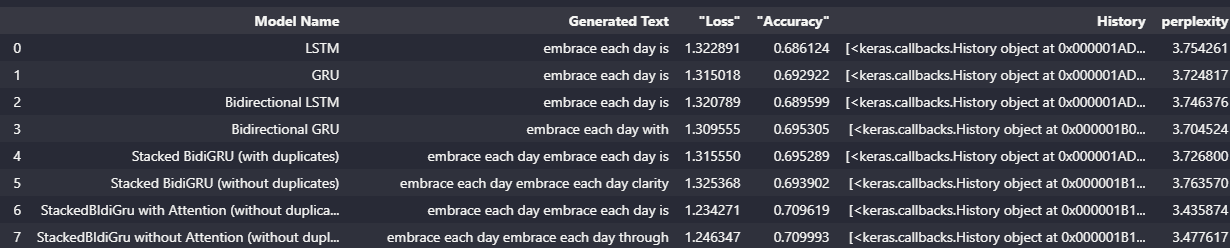

# Evaluation

We can see that the Attention layer has allowed the model to improve to a decent benchmark; however, there are some problems that we have to address first.

1. **Slow Training Time:**
   - To improve the speed of the model, consider increasing the batch size to make full use of the parallelism of the GPU.

2. **Interpretability:**
   - Currently, we are unable to interpret the performance of the model as there is no way to look at the training progress. To address this, we can write a function that will plot out the training progress of the model.

3. **Parameter Tuning:**
   - Most of the parameters are still at their default values. Consider tuning certain parameters to further improve the performance of the model. This could include:
      - The embedding size
      - The width of the layers
      - Learning rate

4. **Making Predictions:**
   - As the models have reached a decent performance, it's time to make proper predictions using the seed texts from the assignment brief. You can use the trained models to generate text and assess the quality of the generated sequences.




In [26]:
def plot_training_progress(history):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    #skip the first 10 epochs to get a better view of the rest of the epochs
    axes[0].plot(history.history['loss'][10:])
    axes[0].set_title('Model loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')

    axes[1].plot(history.history['accuracy'][10:])
    axes[1].set_title('Model accuracy')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_xlabel('Epoch')

    axes[2].plot([np.e**x for x in history.history['loss'][10:]])
    axes[2].set_title('Model perplexity')
    axes[2].set_ylabel('Perplexity')
    axes[2].set_xlabel('Epoch')

    plt.tight_layout()

    plt.show()


In [20]:
#rewrite the fitting function to increase the batch size, as well as to recursively generate text 10 times
def generate_text_recursive(seed_text, tokenizer, max_sequence_len, model):
    generated_text = seed_text
    for _ in range(10):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        predicted_probs = model.predict(token_list, verbose = 0)[0]
        predicted_id = np.random.choice(len(predicted_probs), p=predicted_probs)

        predicted_word = tokenizer.index_word.get(predicted_id, "")
        seed_text += " " + predicted_word

    return seed_text

def fit_model(model, X, y, model_name, RNNdf, tokenizer, max_sequence_len, epochs=10, seed_text=['']):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit the model with duplicates
    history = model.fit(X, y, epochs= epochs, verbose=1, batch_size=1000)
    text_list = []
    for text in seed_text:
        generated_text = generate_text_recursive(text, tokenizer, max_sequence_len, model)
        print(generated_text)
        text_list.append(generated_text)

    RNNdf = pd.concat([RNNdf, pd.DataFrame([{
        'Model Name': model_name + '',
        'Generated Text': text_list,
        '"Loss"': np.min(history.history['loss']),
        '"Accuracy"': np.max(history.history['accuracy']),
        'History': [history]
    }])], ignore_index=True)

    plot_training_progress(history)

    return RNNdf


In [21]:
seed_text_list = ['embrace each day',
                'radiate some',
                'believe that',
                "life's actual purpose is",
                'dance through each and every',
                'let your time and energy',
                'every person is',
                'our country Singapore is',
                'planet earth is',
                'morning and evening would make it']

Epoch 1/100
126/126 [==============================] - 10s 52ms/step - loss: 4.9344 - accuracy: 0.1515
Epoch 2/100
126/126 [==============================] - 7s 52ms/step - loss: 2.5850 - accuracy: 0.4813
Epoch 3/100
126/126 [==============================] - 7s 52ms/step - loss: 1.7030 - accuracy: 0.6263
Epoch 4/100
126/126 [==============================] - 7s 53ms/step - loss: 1.4119 - accuracy: 0.6762
Epoch 5/100
126/126 [==============================] - 7s 53ms/step - loss: 1.2833 - accuracy: 0.6976
Epoch 6/100
126/126 [==============================] - 7s 53ms/step - loss: 1.2172 - accuracy: 0.7066
Epoch 7/100
126/126 [==============================] - 7s 53ms/step - loss: 1.1764 - accuracy: 0.7139
Epoch 8/100
126/126 [==============================] - 7s 52ms/step - loss: 1.1513 - accuracy: 0.7176
Epoch 9/100
126/126 [==============================] - 7s 53ms/step - loss: 1.1352 - accuracy: 0.7183
Epoch 10/100
126/126 [==============================] - 7s 53ms/step - loss: 1.12

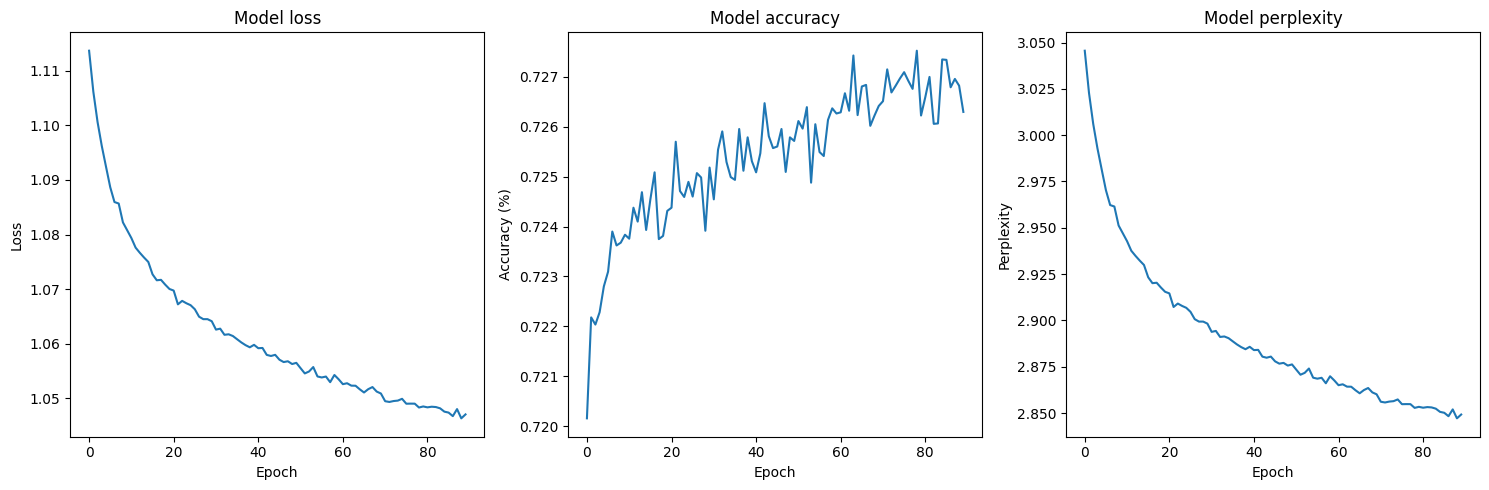

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 33, 256)      306944      ['input_3[0][0]']                
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 33, 128)     123648      ['embedding_8[0][0]']            
 )                                                                                                
                                                                                                  
 attention_weighted_average (At  (None, 33, 128)     0           ['bidirectional_8[0][0]',  

In [35]:
#The models using the dataset with duplicates seem to work the best so we will use that dataset for the rest of the models
# We can now try to increase the embedding layer size as well as the epochs

input = Input(shape=(input_len,))
x = Embedding(total_words, 256, input_length=input_len)(input)
att_in = Bidirectional(GRU(64, return_sequences=True))(x) 
att_out = Attention(name='attention_weighted_average')([att_in, att_in])
x = Concatenate()([att_out, x])
x = GRU(512)(x)
x = Dense(total_words, activation='softmax')(x)
AttentionGRUModelplus = Model(input, x)

RNNdf = fit_model(AttentionGRUModelplus, X, y, 'StackedBIdiGru with Attention (with duplicates)++', RNNdf, tokenizer, max_sequence_len,epochs = 100, seed_text=seed_text_list)

AttentionGRUModelplus.summary()

In [36]:
RNNdf[:1]['Generated Text'][0]

'embrace each day with'

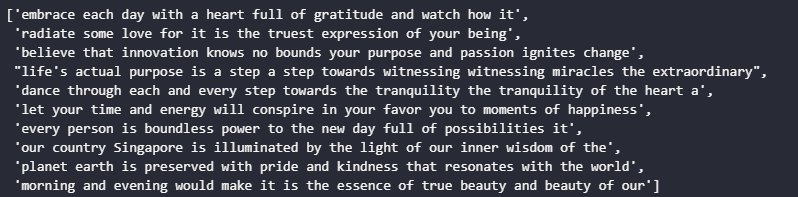

From these example outputs, we can rougly see that the model is able to generate some coherent sentences. For example: 'radiate some love for it is the truest expression of your being'. As well as some incomplete sentences that could make sense once fully formed, for example: 'embrace each day with a heart full of gratitude and watch how it'


Overall, we are limited by the size of the dataset, as well as certain limitations from the assignment, we are unable to train the models to an excellent performance. Due to the nature of the assignment, i will also not be training the RNN model to recognise sentence structures, as we are only required to predict the next word in a sequence, as such we will have to deal with incomplete senteces. 


As a final way to improve our model, we can try to implement lr decay to the model. This will allow the model to learn more efficiently as the learning rate will decrease as the model trains.

In [37]:
from keras.callbacks import ReduceLROnPlateau

input = Input(shape=(input_len,))
x = Embedding(total_words, 256, input_length=input_len)(input)
att_in = Bidirectional(GRU(64, return_sequences=True))(x) 
att_out = Attention(name='attention_weighted_average')([att_in, att_in])
x = Concatenate()([att_out, x])
x = GRU(512)(x)
x = Dense(total_words, activation='softmax')(x)
AttentionGRUModelplus = Model(input, x)


AttentionGRUModelplus.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = AttentionGRUModelplus.fit(X, y, epochs= 100, verbose=1, batch_size=1000, callbacks=[ReduceLROnPlateau(monitor='loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)])

Epoch 1/100
126/126 [==============================] - 10s 53ms/step - loss: 4.8435 - accuracy: 0.1617 - lr: 0.0010
Epoch 2/100
126/126 [==============================] - 7s 52ms/step - loss: 2.6954 - accuracy: 0.4518 - lr: 0.0010
Epoch 3/100
126/126 [==============================] - 7s 53ms/step - loss: 2.0055 - accuracy: 0.5623 - lr: 0.0010
Epoch 4/100
126/126 [==============================] - 7s 52ms/step - loss: 1.6625 - accuracy: 0.6214 - lr: 0.0010
Epoch 5/100
126/126 [==============================] - 7s 53ms/step - loss: 1.4691 - accuracy: 0.6589 - lr: 0.0010
Epoch 6/100
126/126 [==============================] - 7s 52ms/step - loss: 1.3530 - accuracy: 0.6809 - lr: 0.0010
Epoch 7/100
126/126 [==============================] - 7s 52ms/step - loss: 1.2791 - accuracy: 0.6947 - lr: 0.0010
Epoch 8/100
126/126 [==============================] - 7s 52ms/step - loss: 1.2302 - accuracy: 0.7041 - lr: 0.0010
Epoch 9/100
126/126 [==============================] - 7s 52ms/step - loss: 1.1

embrace each day is a canvas for new beginnings and fresh opportunities to
radiate some compassion for it is the language of the soul a
believe that light up our days future of our planet and determination
life's actual purpose is the compass of endless exploration self shine for it is
dance through each and every shore you leave behind a tapestry of unity and aspirations
let your time and energy it holds the promise of a fresh start and new
every person is cherished memories a testament to the beauty and richness that
our country Singapore is alive and thriving compassion in the fulfillment of your potential
planet earth is a treasure trove with the stories of our experiences and
morning and evening would make it is a lullaby for the soul from bitterness and resentment


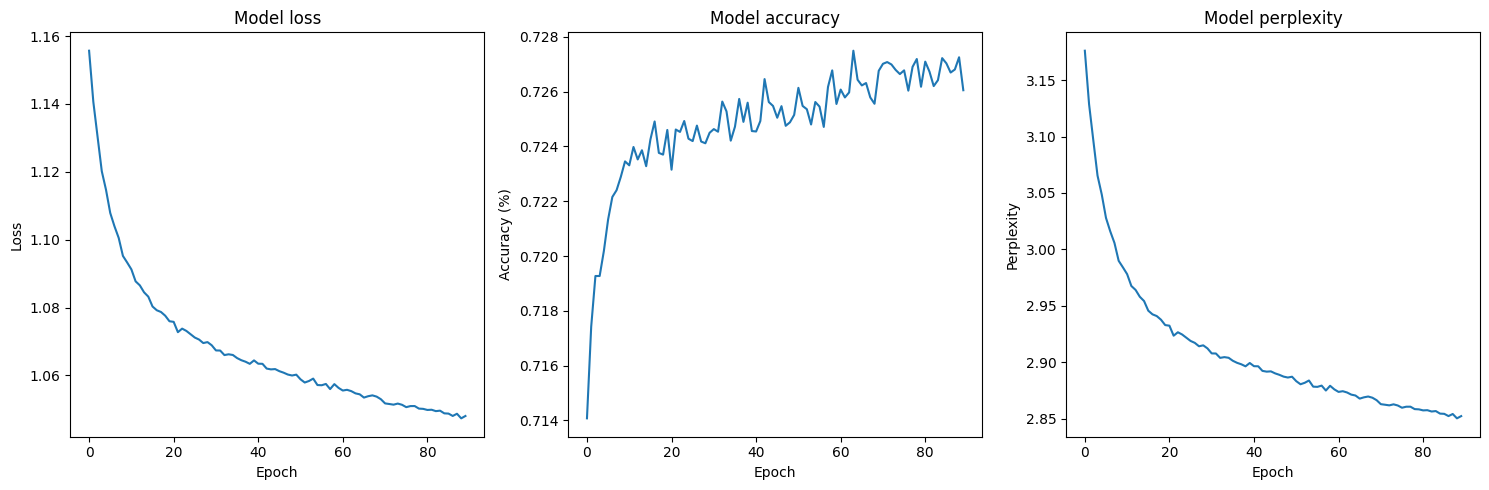

In [38]:
text_list = []
for text in seed_text_list:
    generated_text = generate_text_recursive(text, tokenizer, max_sequence_len, AttentionGRUModelplus)
    print(generated_text)
    text_list.append(generated_text)

RNNdf = pd.concat([RNNdf, pd.DataFrame([{
    'Model Name': 'AttentionGRUModelplus with lrd',
    'Generated Text': text_list,
    '"Loss"': np.min(history.history['loss']),
    '"Accuracy"': np.max(history.history['accuracy']),
    'History': [history]
}])], ignore_index=True)

plot_training_progress(history)

In [39]:
RNNdf

,Model Name,Generated Text,"""Loss""","""Accuracy""",History,perplexity
0,LSTM,embrace each day with,1.333981,0.684115,[<keras.callbacks.History object at 0x000002AF...,3.796125
1,GRU,embrace each day is,1.315441,0.692396,[<keras.callbacks.History object at 0x000002AF...,3.726393
2,Bidirectional LSTM,embrace each day with,1.322457,0.688483,[<keras.callbacks.History object at 0x000002B1...,3.752632
3,Bidirectional GRU,embrace each day with,1.327214,0.692133,[<keras.callbacks.History object at 0x000002B2...,3.770523
4,Stacked BidiGRU (with duplicates),embrace each day embrace each day with,1.317098,0.694500,[<keras.callbacks.History object at 0x000002B1...,3.732574
5,Stacked BidiGRU (without duplicates),embrace each day embrace each day liberation,1.312859,0.695895,[<keras.callbacks.History object at 0x000002B1...,3.716786
6,StackedBIdiGru with Attention (with duplicates),embrace each day embrace each day with,1.191941,0.713126,[<keras.callbacks.History object at 0x000002B1...,3.293468
7,StackedBIdiGru with Attention (without duplica...,embrace each day embrace each day liberation,1.193473,0.712392,[<keras.callbacks.History object at 0x000002B1...,3.298517
8,StackedBIdiGru with Attention (with duplicates)++,[embrace each day with a heart full of gratitu...,1.046311,0.727527,[<keras.callbacks.History object at 0x000002B1...,NaN
9,AttentionGRUModelplus with lrd,[embrace each day is a canvas for new beginnin...,1.047374,0.727495,[<keras.callbacks.History object at 0x000002B2...,NaN


# Evaluation

We can see that the model with lrd is not fully converging, we can try increasing the number of epochs, we can clearly see that there is a high chance that after the model fully converges, the model will perform better than the model without lrd. We can also consider a higher starting learning rate, so that the learning at the start will be faster, leading to faster convergence.

In [23]:
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

input = Input(shape=(input_len,))
x = Embedding(total_words, 256, input_length=input_len)(input)
att_in = Bidirectional(GRU(64, return_sequences=True))(x) 
att_out = Attention(name='attention_weighted_average')([att_in, att_in])
x = Concatenate()([att_out, x])
x = GRU(512)(x)
x = Dense(total_words, activation='softmax')(x)
AttentionGRUModelplus = Model(input, x)


AttentionGRUModelplus.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.01), metrics=['accuracy'])
#increase epochs to 200
history = AttentionGRUModelplus.fit(X, y, epochs= 250, verbose=1, batch_size=1000, callbacks=[ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)])

Epoch 1/250
126/126 [==============================] - 10s 54ms/step - loss: 3.3583 - accuracy: 0.3917 - lr: 0.0100
Epoch 2/250
126/126 [==============================] - 7s 53ms/step - loss: 1.7183 - accuracy: 0.6296 - lr: 0.0100
Epoch 3/250
126/126 [==============================] - 7s 53ms/step - loss: 1.4609 - accuracy: 0.6784 - lr: 0.0100
Epoch 4/250
126/126 [==============================] - 7s 54ms/step - loss: 1.3845 - accuracy: 0.6919 - lr: 0.0100
Epoch 5/250
126/126 [==============================] - 7s 54ms/step - loss: 1.3353 - accuracy: 0.6975 - lr: 0.0100
Epoch 6/250
126/126 [==============================] - 7s 53ms/step - loss: 1.2921 - accuracy: 0.7029 - lr: 0.0100
Epoch 7/250
126/126 [==============================] - 7s 53ms/step - loss: 1.2518 - accuracy: 0.7062 - lr: 0.0100
Epoch 8/250
126/126 [==============================] - 7s 55ms/step - loss: 1.2447 - accuracy: 0.7075 - lr: 0.0100
Epoch 9/250
126/126 [==============================] - 7s 55ms/step - loss: 1.2

embrace each day is a canvas for new beginnings reminding us of the
radiate some resilience and let it be the foundation of your success
believe that spreads joy and contentment reside within you meet has a
life's actual purpose is a pledge to tread lightly on our planet planet planet
dance through each and every day brings your way by it light a guiding star
let your time and energy your dreams aspirations and actions take flight of a nation
every person is a reminder of the earth's fiery core and realized you
our country Singapore is the only one that truly exists a deliberate mark on
planet earth is a tribute to the boundless power of the heart to
morning and evening would make it is the foundation of every action and decision course to


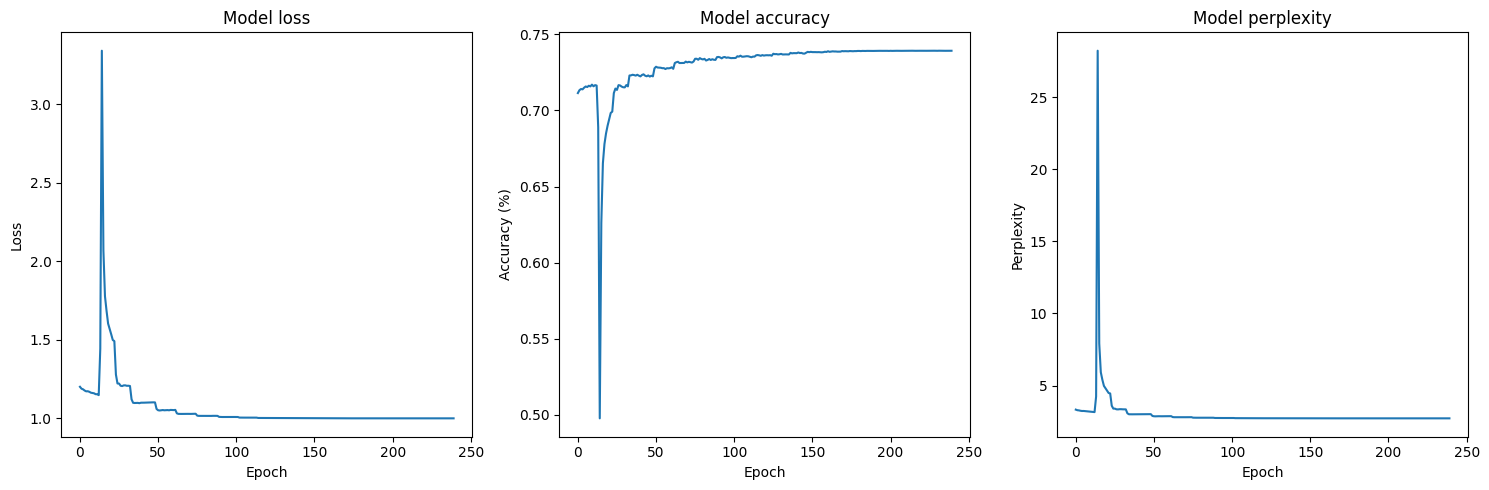

In [69]:
text_list = []
for text in seed_text_list:
    generated_text = generate_text_recursive(text, tokenizer, max_sequence_len, AttentionGRUModelplus)
    print(generated_text)
    text_list.append(generated_text)

RNNdf = pd.concat([RNNdf, pd.DataFrame([{
    'Model Name': 'AttentionGRUModelplus with lrd',
    'Generated Text': text_list,
    '"Loss"': np.min(history.history['loss']),
    '"Accuracy"': np.max(history.history['accuracy']),
    'History': [history]
}])], ignore_index=True)

plot_training_progress(history)

In [72]:
RNNdf['perplexity'] = RNNdf.apply(lambda row: np.min([np.e**x for x in row['History'][0].history['loss']]), axis=1)

RNNdf

,Model Name,Generated Text,"""Loss""","""Accuracy""",History,perplexity,BLEU Score
0,AttentionGRUModelplus with lrd,[embrace each day with a heart full of gratitu...,1.000873,0.739259,[<keras.callbacks.History object at 0x000001B8...,2.720656,0.639618
1,AttentionGRUModelplus with lrd,[embrace each day is a canvas for new beginnin...,1.000873,0.739259,[<keras.callbacks.History object at 0x000001B8...,2.720656,0.678960
2,AttentionGRUModelplus with lrd,[embrace each day is a canvas for new beginnin...,1.000873,0.739259,[<keras.callbacks.History object at 0x000001B8...,2.720656,0.580469


# Evaluation

As perplexity is a metric to evaluate the model, it would be nice to have a metric to measure the "quality" of the generated sentences. We can try using the bleu score to evaluate the quality of the generated sentences. 

In [61]:
with open ('train.csv', 'r') as f:
    data = f.read()
    data = data.split('\n')

In [62]:
data.remove(data[0])
data.remove(data[-1])
#remove the " as well as the commas and fullstops

for i in range(len(data)):
    data[i] = data[i].replace('"', '')
    data[i] = data[i].replace(',', '')
    data[i] = data[i].replace('.', '')
    data[i] = data[i].replace(';', '')


In [63]:
for i in range(len(data)):
    data[i] = data[i].split(' ')

In [78]:
# Initiate the reference text
# We can use the original quotes as the reference text
# Note that we are not using n-gram bleu scores as the "Sentences" generated are not proper sentences and our models are not trained to generate proper sentences
reference_text = data

for index, row in RNNdf.iterrows():
    generated_texts = row['Generated Text']
    scoreslist = []
    print(row['Model Name'], ':')
    for text in generated_texts:
        #tokenize the generated text
        testtext = text.split(' ')
        #calculate the bleu score
        scoreslist.append(sentence_bleu(reference_text, testtext))
        print(text, sentence_bleu(reference_text, testtext))
    RNNdf.at[index, 'BLEU Score'] = np.mean(scoreslist)

AttentionGRUModelplus with lrd :
embrace each day with a heart full of gratitude and kindness and light 0.7598356856515925
radiate some love for it is the truest expression of your humanity 0.8265168183793802
believe that spreads joy and contentment reside within you meet has a 0.5900468726392808
life's actual purpose is a pledge to tread lightly on our planet planet encourages 0.6591844162499148
dance through each and every day is a fresh canvas paint it with vibrant strokes 0.7930768575826375
let your time and energy kindness be the currency of your interactions and your way 0.535802786369768
every person is a reminder of the earth's fiery core and joy in 0.4139790020029942
our country Singapore is a treasure in the chest of memories a a of 0.6003124062338072
planet earth is a sanctuary of serenity within you touch the soul of 0.6190429960963545
morning and evening would make it is the essence of true beauty resides within your soul 0.5983790078367693


## Bleu score explanation

Bilingual Evaluation Understudy Score
The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence.

A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

The score was developed for evaluating the predictions made by automatic machine translation systems. It is not perfect, but does offer 5 compelling benefits:

- It is quick and inexpensive to calculate.
- It is easy to understand.
- It is language independent.
- It correlates highly with human evaluation.
- It has been widely adopted.

In [79]:
RNNdf

,Model Name,Generated Text,"""Loss""","""Accuracy""",History,perplexity,BLEU Score
0,AttentionGRUModelplus with lrd,[embrace each day with a heart full of gratitu...,1.000873,0.739259,[<keras.callbacks.History object at 0x000001B8...,2.720656,0.639618
